In [5]:
import torch
import time
import gc
import math
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pickle
import random

from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim

import sys
sys.path.append('../code')
from python.commons import full_inference_e2e, inc_inference_e2e, adaptive_drilldown, generate_heatmap
from python.imagenet_classes import class_names
from python.vgg16 import VGG16
from python.resnet18 import ResNet18
from python.inception3 import Inception3

random.seed(45)
np.random.seed(45)

torch.set_num_threads(8)

image_file_path = "../code/python/butterfly.jpg"

In [13]:
patch_size = 32
stride = 8
gpu = True

In [14]:
if gpu:
    torch.cuda.synchronize()

prev_time = time.time()
with torch.no_grad():
#     x = full_inference_e2e(VGG16, image_file_path, patch_size, stride, batch_size=128, gpu=gpu)
    x = full_inference_e2e(Inception3, image_file_path, patch_size, stride,
                           batch_size=128, gpu=gpu, image_size=299, x_size=299, y_size=299)

if gpu:
    torch.cuda.synchronize()

full_inference_time = time.time() - prev_time
print("Full Inference Time: " + str(full_inference_time))

Full Inference Time: 2.79389691353


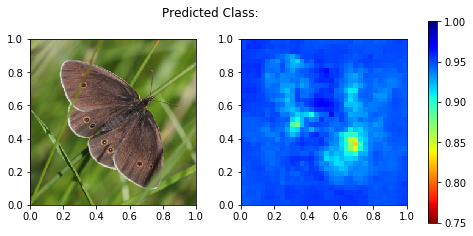

In [15]:
orig_hm  =  generate_heatmap(image_file_path, x, show=True, width=299, alpha=1.0)

output = open('temp', 'w')
pickle.dump(orig_hm, output)
output.close()

In [16]:
gc.collect()
torch.cuda.empty_cache()

In [19]:
def inc_inference(beta, patch_size=4, stride=1, adaptive=False):
    if gpu:
        torch.cuda.synchronize()
    
    if not adaptive:
        with torch.no_grad():
            x = inc_inference_e2e(Inception3, image_file_path, patch_size, stride,
                                  batch_size=256, beta=beta, gpu=gpu, version='v2',
                                 image_size=299, x_size=299, y_size=299)
    else:
        with torch.no_grad():
            x = adaptive_drilldown(VGG16, image_file_path, patch_size, stride,
                                    batch_size=256, beta=beta, percentile=20)
    if gpu:
        torch.cuda.synchronize()

    return x

BETA: 1.0 Inference Time: 20.9588179588


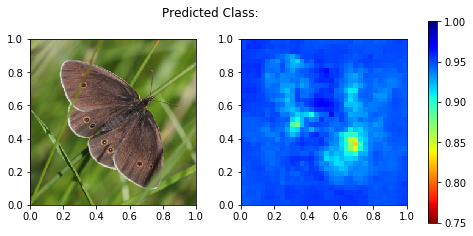

BETA: 0.9 Inference Time: 22.6674280167


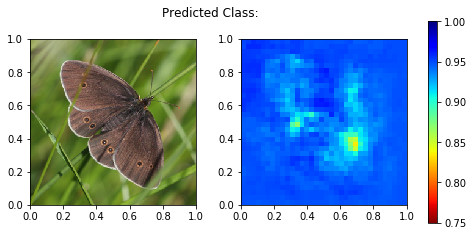

BETA: 0.8 Inference Time: 22.4584989548


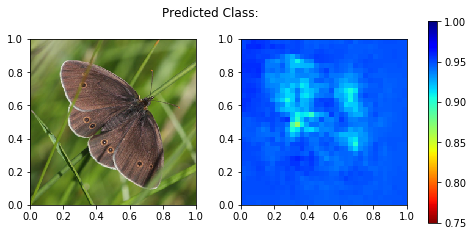

BETA: 0.7 Inference Time: 20.9216887951


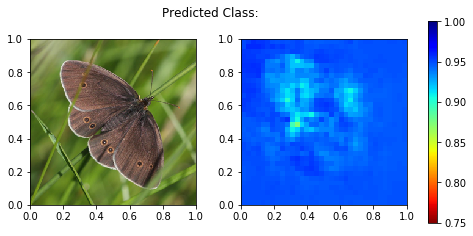

BETA: 0.6 Inference Time: 19.2209000587


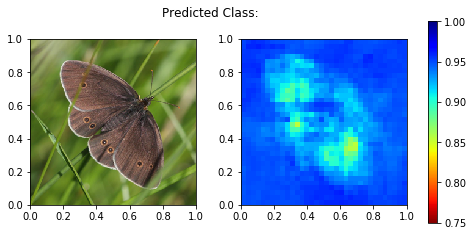

BETA: 0.5 Inference Time: 17.55210495


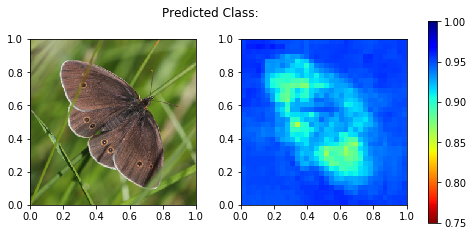

BETA: 0.4 Inference Time: 15.4305930138


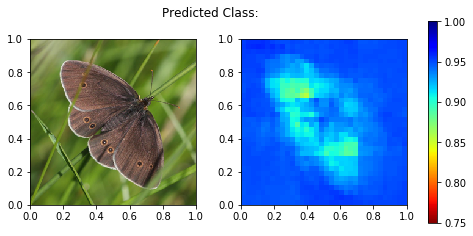

In [20]:
orig_hm = pickle.load(open('temp', 'r'))

times = []
score = []

taus = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]

for beta in taus:
    prev_time = time.time()
    x = inc_inference(beta, patch_size=patch_size, stride=stride)
    inc_inference_time = time.time()-prev_time
    times.append(inc_inference_time)
    
    label = "BETA: " + str(beta) +" Inference Time: " + str(inc_inference_time)
    print(label)
    hm = generate_heatmap(image_file_path, x, show=True, width=299, alpha=1.0)
    
    if hm.shape[0] < 7:
        win_size=3
    else:
        win_size=None
    
    score.append(ssim(orig_hm, hm, data_range=255, multichannel=True, win_size=win_size))